In [ ]:
! pip install deepxde

Résolution Couplée pour l'Élasticité Linéaire

Nature du Problème : Ce code aborde un problème d'élasticité linéaire en 3D où les composantes de déplacement (u, v, w) sont couplées par les équations d'équilibre.
Approche : Les trois composantes sont résolues simultanément dans un seul modèle en utilisant un réseau de neurones avec trois sorties, représentant u,v et w.
Réseau de Neurones Unifié

Structure : Un seul réseau de neurones est utilisé avec trois sorties, correspondant aux trois composantes de déplacement (u, v, w).
Couplage : Le réseau apprend simultanément les solutions pour toutes les composantes, capturant ainsi les interactions et le couplage entre elles.
Efficacité : Cette méthode est généralement plus efficace pour des problèmes couplés, réduisant la complexité de gestion multiple des modèles.
Conditions de Dirichlet et Neumann

Définition :
Dirichlet : Fixe les déplacements (𝑢𝑥=0 ux=0, 𝑢𝑦=0 uy=0, 𝑢𝑧=0 uz=0) sur la face gauche.
Neumann : Applique une condition de force (force appliquée dans la direction y) sur la face supérieure.
Complexité : Gère à la fois les conditions de Dirichlet et de Neumann, ce qui est typique pour les problèmes d'élasticité où des charges peuvent être appliquées sur certaines faces.

 Équations d'Équilibre en Élasticité Linéaire

Définition des PDE : Implémente les équations d'équilibre de l'élasticité linéaire en 3D, impliquant les dérivées des composantes de contrainte (Sxx, Syy , etc.) et les paramètres matériels (λ,μ).
Couplage : Les équations pour u, v, w sont couplées, reflétant les interactions physiques entre les directions spatiales dans le matériau élastique.

Utilisation de TensorFlow

Bibliothèques : Importe TensorFlow pour la gestion des réseaux de neurones.
Intégration : DeepXDE s'intègre naturellement avec TensorFlow pour les opérations de différenciation automatique et l'entraînement des modèles.

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.105905 s

'compile' took 4.551225 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [3.76e-02, 8.96e-02, 9.97e-02, 1.32e-02, 2.48e-03, 1.41e-01, 8.33e-02]    [3.76e-02, 8.96e-02, 9.97e-02, 1.32e-02, 2.48e-03, 1.41e-01, 8.33e-02]    []  
1000      [5.51e-05, 9.52e-05, 1.24e-05, 3.86e-06, 1.19e-05, 1.82e-06, 8.33e-02]    [5.51e-05, 9.52e-05, 1.24e-05, 3.86e-06, 1.19e-05, 1.82e-06, 8.33e-02]    []  
2000      [1.32e-05, 2.00e-05, 5.42e-06, 1.33e-06, 4.47e-06, 6.40e-07, 8.33e-02]    [1.32e-05, 2.00e-

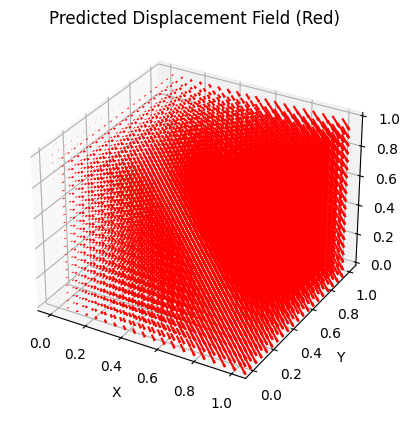

In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
force_magnitude = 0.5  # Magnitude of the force applied on the top face

# Define geometry for a 3D cuboid
geom = dde.geometry.Cuboid([0, 0, 0], [1, 1, 1])

# Boundary condition functions
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

# Fixed boundary on the left face (ux=0, uy=0, uz=0)
bc_left_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)  # ux=0 on left face
bc_left_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)  # uy=0 on left face
bc_left_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=2)  # uz=0 on left face

# Neumann boundary condition for a force on the top face (y=1)
def force_on_top(inputs, outputs, X):
    force_x = np.zeros_like(X[:, 0])  # No force in the x direction
    force_y = -force_magnitude * np.ones_like(X[:, 1])  # Force in the negative y direction
    force_z = np.zeros_like(X[:, 2])  # No force in the z direction
    return np.stack([force_x, force_y, force_z], axis=1)

bc_force_top = dde.icbc.OperatorBC(geom, force_on_top, boundary_top)

# Define the boundary conditions list
bc = [bc_left_x, bc_left_y, bc_left_z, bc_force_top]

# Define PDE for 3D linear elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations
    eq_x = dde.grad.jacobian(Sxx, X, j=0) + dde.grad.jacobian(Sxy, X, j=1) + dde.grad.jacobian(Sxz, X, j=2)
    eq_y = dde.grad.jacobian(Sxy, X, j=0) + dde.grad.jacobian(Syy, X, j=1) + dde.grad.jacobian(Syz, X, j=2)
    eq_z = dde.grad.jacobian(Sxz, X, j=0) + dde.grad.jacobian(Syz, X, j=1) + dde.grad.jacobian(Szz, X, j=2)

    return [eq_x, eq_y, eq_z]

# Define the model
data = dde.data.PDE(geom, pde, bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-4)
model.train(epochs=10000)

# Visualization function to show the displacement
def plot_displacement(model):
    # Create a grid of points in the cube
    x = np.linspace(0, 1, 20)
    y = np.linspace(0, 1, 20)
    z = np.linspace(0, 1, 20)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]

    # Plotting predicted displacement
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.quiver(points[:, 0], points[:, 1], points[:, 2],
              u_pred[:, 0], u_pred[:, 1], u_pred[:, 2], color="red")
    ax.set_title("Predicted Displacement Field (Red)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Call the plotting function
plot_displacement(model)
